# Customer Churn Prediction with Amazon SageMaker Autopilot


## Content

1. [Prerequisites](#Prerequisites)
1. [Preparing the dataset](#Preparing)
1. [Setting up the SageMaker Autopilot Job](#Settingup)
1. [Launching the SageMaker Autopilot Job](#Launching)
1. [Monitoring the SageMaker Autopilot Job](#Monitoring)
1. [Reviewing Results](#Results) 
1. [Performing Inference](#Inference) 

<div class="alert alert-block alert-info">
<b><h1>1. Prerequisites</h1></div>
<a class="anchor" id="Prerequisites"></a>

Two tasks below have to be completed as prerequisites:

- The Amazon Simple Storage Service (Amazon S3) bucket and prefix that you want to use for training and model data.
- The IAM role to give Autopilot access to your data. 

In [1]:
# Import required libraries
import sagemaker
import boto3
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from IPython.core.display import display, HTML
from sagemaker.analytics import ExperimentAnalytics


# Define region, bucket
session = sagemaker.Session()
region = boto3.Session().region_name
bucket = session.default_bucket()

# Select an IAM role
role = 'arn:aws:iam::690429675927:role/role_sagemaker' 
   
# Define sm object to be used to call Sagemaker services 
sm = boto3.Session().client(service_name='sagemaker',region_name=region)


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<div class="alert alert-block alert-info">
<b><h1>2. Preparing the dataset</h1></div>
<a class="anchor" id="Preparing"></a>

The dataset used for this notebook is a IBM Watson Telco Dataset. This dataset describes a binary classification problem where the <strong>“Churn”</strong> column is the target.

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/rstudio/keras-customer-churn/master/data/WA_Fn-UseC_-Telco-Customer-Churn.csv',nrows=1000)
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 10) 
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Defining the target attribute

In [4]:
target_column='Churn'

### Dividing the data into training and testing splits

The training split is used by SageMaker Autopilot. The testing split is reserved to perform inference using the suggested model.


In [5]:
train_data = data.sample(frac=0.8,random_state=200)
test_data = data.drop(train_data.index)
test_data_no_target = test_data.drop(columns=[target_column])

In [6]:
train_data.shape, test_data.shape

((800, 21), (200, 21))

### Uploading the dataset to Amazon S3
Copy the file to Amazon Simple Storage Service (Amazon S3) in a .csv format for Amazon SageMaker training to use.

In [7]:
# Define the S3 bucket and prefix(subfolder within the bucket)
prefix = 'sagemaker/telco'

train_file = 'train_data.csv';
train_data.to_csv(train_file, index=False, header=True)
train_data_s3_path = session.upload_data(path=train_file, key_prefix=prefix + "/train")

display(HTML('<b>Train data uploaded to → </b>'  + train_data_s3_path))

test_file = 'test_data.csv';
test_data_no_target.to_csv(test_file, index=False, header=False)
test_data_s3_path = session.upload_data(path=test_file, key_prefix=prefix + "/test")

display(HTML('<b>Test data uploaded to → </b>'  + test_data_s3_path))

<div class="alert alert-block alert-info">
<b><h1>3. Setting up the SageMaker Autopilot Job</h1></div>
<a class="anchor" id="Settingup"></a>

In order to invoke Autopilot service to train the model, the inputs below are required:

* Amazon S3 location for input dataset and for all output artifacts
* Name of the column of the dataset you want to predict (`target_column` in this case) 
* An IAM role
    
Optional inputs:
* Tags

In [8]:
# Define max number of candidates
max_candidates = 3

job_config = {
    'CompletionCriteria': {
      'MaxRuntimePerTrainingJobInSeconds': 300,
      'MaxCandidates': max_candidates,
      'MaxAutoMLJobRuntimeInSeconds': 1800
    },
}

input_data_config = [{
      'DataSource': {
        'S3DataSource': {
          'S3DataType': 'S3Prefix',
          'S3Uri': 's3://{}/{}/train'.format(bucket,prefix)
        }
      },
      'TargetAttributeName': target_column
    }
  ]

output_data_config = {
    'S3OutputPath': 's3://{}/{}/output'.format(bucket,prefix)
  }

# Define a Tag to be used as filter
tags_config = [ { 
         "Key": "Project",
         "Value": "Project_Telco"
          }
   ]

You can also specify the type of problem you want to solve with your dataset (`Regression, MulticlassClassification, BinaryClassification`). In case you are not sure, SageMaker Autopilot will infer the problem type based on statistics of the target column (the column you want to predict). 

You have the option to limit the running time of a SageMaker Autopilot job by providing either the maximum number of pipeline evaluations or candidates (one pipeline evaluation is called a `Candidate` because it generates a candidate model) or providing the total time allocated for the overall Autopilot job. Under default settings, this job takes about four hours to run. This varies between runs because of the nature of the exploratory process Autopilot uses to find optimal training parameters.

<div class="alert a4-block alert-info">
<b><h1>4. Launching the SageMaker Autopilot Job</h1></div>
<a class="anchor" id="Launching"></a>

You can now launch the Autopilot job by calling the `create_auto_ml_job` API. 

In [9]:
from time import gmtime, strftime, sleep

# Define AutoMLJobName
timestamp_suffix = strftime('%Y-%m-%d-%H-%M-%S', gmtime())
model_prefix  = 'automl-telco'

auto_ml_job_name =  model_prefix + '-' + timestamp_suffix

display(HTML('<b>AutoMLJobName → </b>'  + auto_ml_job_name))

sm.create_auto_ml_job(AutoMLJobName=auto_ml_job_name,
                      InputDataConfig=input_data_config,
                      OutputDataConfig=output_data_config,
                      AutoMLJobConfig=job_config,
                      RoleArn=role,
                      Tags=tags_config)

{'AutoMLJobArn': 'arn:aws:sagemaker:us-east-1:690429675927:automl-job/automl-telco-2020-10-01-02-31-36',
 'ResponseMetadata': {'RequestId': '7a8078cd-d195-4727-ba9e-1eebc1415d14',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '7a8078cd-d195-4727-ba9e-1eebc1415d14',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '103',
   'date': 'Thu, 01 Oct 2020 02:31:39 GMT'},
  'RetryAttempts': 0}}

<div class="alert a4-block alert-info">
<b><h1>5. Monitoring SageMaker Autopilot job progress</h1></div>
<a class="anchor" id="Monitoring"></a>

The following code will check the job's status every 30 seconds until the high-level steps complete:

* Analyzing Data, where the dataset is analyzed and Autopilot comes up with a list of ML pipelines that should be tried out on the dataset. The dataset is also split into train and validation sets.
* Feature Engineering, where Autopilot performs feature transformation on individual features of the dataset as well as at an aggregate level.
* Model Tuning, where the top performing pipeline is selected along with the optimal hyperparameters for the training algorithm (the last stage of the pipeline). 

In [10]:
%%time

display(HTML('<u><b>JobStatus &nbsp&nbsp&nbsp&nbsp-&nbsp&nbsp&nbsp&nbsp Secondary Status</b></u>' ))
describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
job_run_status = describe_response['AutoMLJobStatus']
    
while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_run_status = describe_response['AutoMLJobStatus']
    print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
    sleep(30)  

InProgress - Starting
InProgress - Starting
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgr

<div class="alert a4-block alert-info">
<b><h1>6. Reviewing Results</h1></div>
<a class="anchor" id="Results"></a>

### Let's review all jobs in the <strong>SageMaker Console</strong>. 

In [11]:
review_aws_list =['<b><p style="text-align:left"><a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/">Processing Jobs</a></p></b>'.format(region),
     '<b><p style="text-align:left"><a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/">Training Jobs</a></p></b>'.format(region),
     '<b><p style="text-align:left"><a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/hyper-tuning-jobs/">Hyperparameter Tuning Jobs</a></p></b>'.format(region),
     '<b><p style="text-align:left"><a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/models/">Models</a></p></b>'.format(region)
                 ]

df=pd.DataFrame(review_aws_list, columns=['SageMaker Console Links']).set_index('SageMaker Console Links')
display(HTML(df.to_html( render_links=True, escape=False)))

""
SageMaker Console Links
Processing Jobs
Training Jobs
Hyperparameter Tuning Jobs
Models


### Let's review all Candidates

You can view all the candidates (pipeline evaluations with different hyperparameter combinations) that were explored by SageMaker Autopilot. To find them, code below will use the search function to retrieve jobs based on the Tag previously defined.

In [13]:
results = sm.search(
    Resource='TrainingJob',
    SearchExpression={
        'Filters': [
            {
                'Name': 'Tags.Project',
                'Operator': 'Equals',
                'Value': 'Project_Telco'}]},
    SortBy = "CreationTime",
    SortOrder = "Descending"
)

In [14]:
headers=["Training Job Name","Algorithm Specification", "Status","Metric","Metric Value","Training Time","BillableTime","Creation Time"]
rows=[]
for result in results['Results']: 
    trainingJob = result['TrainingJob']
    if (not trainingJob['AlgorithmSpecification']['MetricDefinitions']==[] and not trainingJob['TrainingJobStatus']== 'Failed'):
        rows.append([
         '<a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">{}</a>'.format(region,trainingJob['TrainingJobName'],trainingJob['TrainingJobName']),
         trainingJob['AlgorithmSpecification']['TrainingImage'].split("amazonaws.com/",1)[1],
         trainingJob['TrainingJobStatus'],
         trainingJob['FinalMetricDataList'][0]['MetricName'],
         trainingJob['FinalMetricDataList'][0]['Value'],               
         trainingJob['TrainingTimeInSeconds'],                 
         trainingJob['BillableTimeInSeconds'],
         trainingJob['CreationTime'],
    ])
        
    if (not trainingJob['AlgorithmSpecification']['MetricDefinitions']==[] and trainingJob['TrainingJobStatus']== 'Failed'):
        rows.append([
        '<a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">{}</a>'.format(region,trainingJob['TrainingJobName'],trainingJob['TrainingJobName']),
         trainingJob['AlgorithmSpecification']['TrainingImage'].split("amazonaws.com/",1)[1],
         trainingJob['TrainingJobStatus'],
         '',
         '',               
         trainingJob['TrainingTimeInSeconds'],                 
         trainingJob['BillableTimeInSeconds'],
         trainingJob['CreationTime']
    ])

df = pd.DataFrame(data=rows,columns=headers)

display(HTML(df.to_html( render_links=True, escape=False)))

,Training Job Name,Algorithm Specification,Status,Metric,Metric Value,Training Time,BillableTime,Creation Time
0,tuning-job-1-9d22a30d195e4dbe94-003-b81b9ca3,sagemaker-xgboost:1.0-1-cpu-py3,Completed,validation:f1,0.61237,47,47,2020-09-30 19:49:49-07:00
1,tuning-job-1-9d22a30d195e4dbe94-002-8df5e337,sagemaker-xgboost:1.0-1-cpu-py3,Completed,validation:f1,0.61237,53,53,2020-09-30 19:49:47-07:00
2,tuning-job-1-9d22a30d195e4dbe94-001-ac0354f9,sagemaker-xgboost:1.0-1-cpu-py3,Completed,validation:f1,0.61237,46,46,2020-09-30 19:49:46-07:00
3,tuning-job-1-9a6201748f64438998-003-c63c5637,sagemaker-xgboost:1.0-1-cpu-py3,Completed,validation:f1,0.53911,43,43,2020-09-30 19:19:36-07:00
4,tuning-job-1-9a6201748f64438998-002-af2f1b46,sagemaker-xgboost:1.0-1-cpu-py3,Completed,validation:f1,0.53911,71,71,2020-09-30 19:19:35-07:00
5,tuning-job-1-9a6201748f64438998-001-ceb9f6de,sagemaker-xgboost:1.0-1-cpu-py3,Completed,validation:f1,0.68651,50,50,2020-09-30 19:19:34-07:00


### Inspect Trials using Experiments API

SageMaker Autopilot automatically creates a new experiment, and pushes information for each trial.

In [15]:
exp = ExperimentAnalytics(sagemaker_session=session,experiment_name=auto_ml_job_name + '-aws-auto-ml-job')
df = exp.dataframe()
print("Number of jobs: ", len(df))

df = pd.concat([df['ObjectiveMetric - Max'], df.drop(['ObjectiveMetric - Max'], axis=1)], axis=1)

df.sort_values('ObjectiveMetric - Max', ascending=0).head(len(df))

Number of jobs:  10


,ObjectiveMetric - Max,TrialComponentName,DisplayName,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,_tuning_objective_metric,alpha,colsample_bytree,eta,gamma,lambda,max_depth,min_child_weight,num_round,objective,save_model_on_termination,subsample,ObjectiveMetric - Min,ObjectiveMetric - Avg,ObjectiveMetric - StdDev,ObjectiveMetric - Last,ObjectiveMetric - Count,train:f1 - Min,train:f1 - Max,train:f1 - Avg,train:f1 - StdDev,train:f1 - Last,train:f1 - Count,validation:error - Min,validation:error - Max,validation:error - Avg,validation:error - StdDev,validation:error - Last,validation:error - Count,validation:f1 - Min,validation:f1 - Max,validation:f1 - Avg,validation:f1 - StdDev,validation:f1 - Last,validation:f1 - Count,train:error - Min,train:error - Max,train:error - Avg,train:error - StdDev,train:error - Last,train:error - Count,train - MediaType,train - Value,validation - MediaType,validation - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,Trials,Experiments,SageMaker.ModelName,SageMaker.ModelPrimary.DataUrl,SageMaker.ModelPrimary.Image,SageMaker.TransformInput - MediaType,SageMaker.TransformInput - Value,SageMaker.TransformOutput - MediaType,SageMaker.TransformOutput - Value,processor_module,sagemaker_program,sagemaker_submit_directory,code - MediaType,code - Value,input_channel_mode,job_name,label_col,max_dataset_size,SageMaker.ImageUri - MediaType,SageMaker.ImageUri - Value,ds - MediaType,ds - Value
0,0.61345,tuning-job-1-9d22a30d195e4dbe94-003-b81b9ca3-a...,tuning-job-1-9d22a30d195e4dbe94-003-b81b9ca3-a...,arn:aws:sagemaker:us-east-1:690429675927:train...,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.m5.4xlarge,50.0,validation:f1,0.00337,0.499484,0.00211,0.001007,0.000326,17.0,0.003029,2.0,binary:logistic,true,0.595006,0.61237,0.61291,0.000764,0.61237,2.0,0.85107,0.85176,0.851415,0.000488,0.85107,2.0,0.29192,0.29814,0.29503,0.004398,0.29192,2.0,0.61237,0.61345,0.61291,0.000764,0.61237,2.0,0.11111,0.11268,0.111895,0.00111,0.11111,2.0,text/csv,s3://sagemaker-us-east-1-690429675927/sagemake...,text/csv,s3://sagemaker-us-east-1-690429675927/sagemake...,NaN,s3://sagemaker-us-east-1-690429675927/sagemake...,[tuning-job-1-9d22a30d195e4dbe94-003-b81b9ca3-...,[automl-telco-2020-10-01-02-31-36-aws-auto-ml-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.61345,tuning-job-1-9d22a30d195e4dbe94-002-8df5e337-a...,tuning-job-1-9d22a30d195e4dbe94-002-8df5e337-a...,arn:aws:sagemaker:us-east-1:690429675927:train...,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.m5.4xlarge,50.0,validation:f1,0.00337,0.499484,0.00211,0.001007,0.000326,17.0,0.003029,2.0,binary:logistic,true,0.595006,0.61237,0.61291,0.000764,0.61237,2.0,0.85107,0.85176,0.851415,0.000488,0.85107,2.0,0.29192,0.29814,0.29503,0.004398,0.29192,2.0,0.61237,0.61345,0.61291,0.000764,0.61237,2.0,0.11111,0.11268,0.111895,0.00111,0.11111,2.0,text/csv,s3://sagemaker-us-east-1-690429675927/sagemake...,text/csv,s3://sagemaker-us-east-1-690429675927/sagemake...,NaN,s3://sagemaker-us-east-1-690429675927/sagemake...,[tuning-job-1-9d22a30d195e4dbe94-002-8df5e337-...,[automl-telco-2020-10-01-02-31-36-aws-auto-ml-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.61345,tuning-job-1-9d22a30d195e4dbe94-001-ac0354f9-a...,tuning-job-1-9d22a30d195e4dbe94-001-ac0354f9-a...,arn:aws:sagemaker:us-east-1:690429675927:train...,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.m5.4xlarge,50.0,validation:f1,0.00337,0.499484,0.00211,0.001007,0.000326,17.0,0.003029,2.0,binary:logistic,true,0.595006,0.61237,0.61291,0.000764,0.61237,2.0,0.85107,0.85176,0.851415,0.000488,0.85107,2.0,0.29192,0.29814,0.29503,0.004398,0.29192,2.0,0.61237,0.61345,0.61291,0.000764,0.61237,2.0,0.11111,0.11268,0.111895,0.00111,0.11111,2.0,text/csv,s3://sagemaker-us-east-1-690429675927/sagemake...,text/csv,s3://sagemaker-us-east-1-690429675927/sagemake.

### Let's review the Best Candidate

In [16]:
best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['BestCandidate']

best_candidate_dict = {"Candidate Name" : best_candidate['CandidateName'],
     "Candidate Status" : best_candidate['CandidateStatus'],
     "Objective Metric Name" : best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'],
     "Objective Metric Value" : str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']),
     "Training Duration (Tuning)" : str(best_candidate['EndTime'] - best_candidate['CreationTime'])
    }

display(pd.DataFrame.from_dict(best_candidate_dict, orient='index' , columns=['Best Candidate Details']))
display()
display(HTML('<a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">Click for More Best Candidate Details</a>'.format(region, best_candidate['CandidateSteps'][1]['CandidateStepName'] )))
display(HTML('<a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">Click for More Best Candidate (Tuning) Details</a>'.format(region, best_candidate['CandidateSteps'][3]['CandidateStepName'] )))

,Best Candidate Details
Candidate Name,tuning-job-1-9d22a30d195e4dbe94-001-ac0354f9
Candidate Status,Completed
Objective Metric Name,validation:f1
Objective Metric Value,0.6123700141906738
Training Duration (Tuning),0:00:46


### Reviewing Generated Notebook
Once the data analysis is complete, the two auto-generated notebooks are available. 
* Data Exploration
* Candidate Definition

In [17]:
job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)

while 'DataExplorationNotebookLocation' not in job_description_response['AutoMLJobArtifacts'].keys():
    job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    print('[INFO] Autopilot Job has not yet generated the notebooks. Please wait. ')
    print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))
    print('[INFO] Waiting for DataExplorationNotebookLocation...')
    sleep(15)

print('[OK] DataExplorationNotebookLocation found.')

[OK] DataExplorationNotebookLocation found.


In [18]:
generated_resources = job_description_response['AutoMLJobArtifacts']['DataExplorationNotebookLocation'].rstrip('notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb')

pr_job_id = generated_resources.rsplit('/', 1)[-1]

In [19]:
from IPython.core.display import display, HTML

if not pr_job_id: 
    print('No AutoMLJobArtifacts found.')
else: 
    display(HTML('<b> <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/output/{}/sagemaker-automl-candidates/{}/">S3 Generated Resources</a></b>'.format(bucket,prefix, auto_ml_job_name, pr_job_id)))

<div class="alert a4-block alert-info">
<b><h1>7. Performing batch inference </h1></div>
<a class="anchor" id="Inference"></a>

### Let's perform batch inference using the best candidate

In the dataset preparation step, a test data was generated. In this step, you generate offline or [batch inference](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) from the trained model to evaluate the model performance on unseen test data.

In [20]:
model_name = model_prefix + '-' + timestamp_suffix

model = sm.create_model(Containers=best_candidate['InferenceContainers'],
                            ModelName=model_name,
                            ExecutionRoleArn=role)

print('Model ARN corresponding to the best candidate is : {}'.format(model['ModelArn']))

Model ARN corresponding to the best candidate is : arn:aws:sagemaker:us-east-1:690429675927:model/automl-telco-2020-10-01-02-31-36


A transform job uses a trained model to get inferences on a dataset and saves these results to the Amazon S3 location `S3OutputPath`

In [21]:
transform_job_name = model_prefix + '-' + timestamp_suffix

transform_input = {
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': test_data_s3_path
            }
        },
        'ContentType': 'text/csv',
        'CompressionType': 'None',
        'SplitType': 'Line'
    }

transform_output = {
        'S3OutputPath': 's3://{}/{}/inference-results'.format(bucket,prefix),
    }

transform_resources = {
        'InstanceType': 'ml.m5.4xlarge',
        'InstanceCount': 1
    }



sm.create_transform_job(TransformJobName = transform_job_name,
                        ModelName = model_name,
                        TransformInput = transform_input,
                        TransformOutput = transform_output,
                        TransformResources = transform_resources
)

{'TransformJobArn': 'arn:aws:sagemaker:us-east-1:690429675927:transform-job/automl-telco-2020-10-01-02-31-36',
 'ResponseMetadata': {'RequestId': '98219ed7-7295-4390-9fc5-49c73febbd24',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '98219ed7-7295-4390-9fc5-49c73febbd24',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '109',
   'date': 'Thu, 01 Oct 2020 02:56:08 GMT'},
  'RetryAttempts': 0}}

### Tracking the transform job for completion.

In [22]:
%%time

display(HTML('<u><b>JobStatus</b></u>' ))

describe_response = sm.describe_transform_job(TransformJobName = transform_job_name)
job_run_status = describe_response['TransformJobStatus']
print (job_run_status)

while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_transform_job(TransformJobName = transform_job_name)
    job_run_status = describe_response['TransformJobStatus']
    print (job_run_status)
    sleep(30)

InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed
Wall time: 6min 5s


### Now let's view the results of the transform job:

In [24]:
s3_output_key = '{}/inference-results/test_data.csv.out'.format(prefix);
local_inference_results_path = 'inference_results.csv'

s3 = boto3.resource('s3')
inference_results_bucket = s3.Bucket(session.default_bucket())

inference_results_bucket.download_file(s3_output_key, local_inference_results_path);

data = pd.read_csv(local_inference_results_path, header=None, names=(['Predicted']))
pd.set_option('display.max_rows', 10) 
data

,Predicted
0,Yes
1,No
2,No
3,Yes
4,Yes
...,...
195,Yes
196,No
197,No
198,Yes


### Ploting the confusion matrix.

Confusion matrix, without normalization


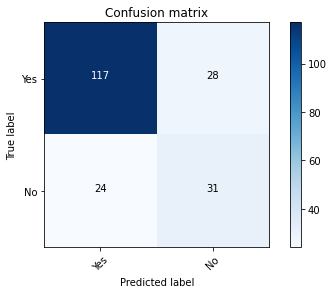

In [25]:
data['Label']= test_data[target_column].to_list()
cm = confusion_matrix(data['Label'], data['Predicted'])
plot_confusion_matrix(cm, classes=['Yes', 'No'], title='Confusion matrix')

### Calculating the model accuracy.

In [26]:
print("Accuracy Score = {}".format(accuracy_score(data['Label'] , data['Predicted'])))

Accuracy Score = 0.74
